In [17]:
import pandas as pd
import numpy as np
import time
import math
from scipy import stats
from tabulate import tabulate
from pprint import pprint
import matplotlib.pyplot as plt


__Preprocessing the data__

In [18]:
def data_loading():
    """
    Load the data from the excel file and preprocess it.
    
    Returns:
    - data (pd.DataFrame): Preprocessed data.
    """
    # Load the data from the excel file
    data = pd.read_excel('gasstationdata33.xlsx')
    
    # Drop the 'Unnamed: 0' column
    data = data.drop(columns=['Unnamed: 0'])

    data = pd.DataFrame(data)
    
    arrivals_datetime = [arrival.to_pydatetime() for arrival in data["Arrival Time"]]

    data["Interarrival Times"] = data["Arrival Time"].diff().dt.total_seconds().fillna(0)
    

    # Calculate the hour of the day
    data['Arrival Time (H)'] = data['Arrival Time'].dt.hour

    # replace nan values in Parking preference with None
    data['Parking preference'] = data['Parking Preference'].fillna('None')

    # fix this mask
    data["Shope-time-no-zero"] = data[data["Shop time"] > 0 ]["Shop time"]
    
    # Convert the attributes to minutes
    attributes = ['Service time Fuel', 'Shop time', 'Service time payment', 'Interarrival Times', 'Shope-time-no-zero']
    
    return data

data = data_loading()
data.head()

,Customer,Arrival Time,Parking Preference,Service time Fuel,Shop time,Service time payment,Interarrival Times,Arrival Time (H),Parking preference,Shope-time-no-zero
0,0,2024-02-01 06:00:06.644,NaN,181,0,46,0.000,6,None,NaN
1,1,2024-02-01 06:03:05.847,Left,158,29,38,179.203,6,Left,29.0
2,2,2024-02-01 06:05:45.348,NaN,357,0,39,159.501,6,None,NaN
3,3,2024-02-01 06:07:31.426,Right,802,0,37,106.078,6,Right,NaN
4,4,2024-02-01 06:15:28.037,Right,359,0,50,476.611,6,Right,NaN


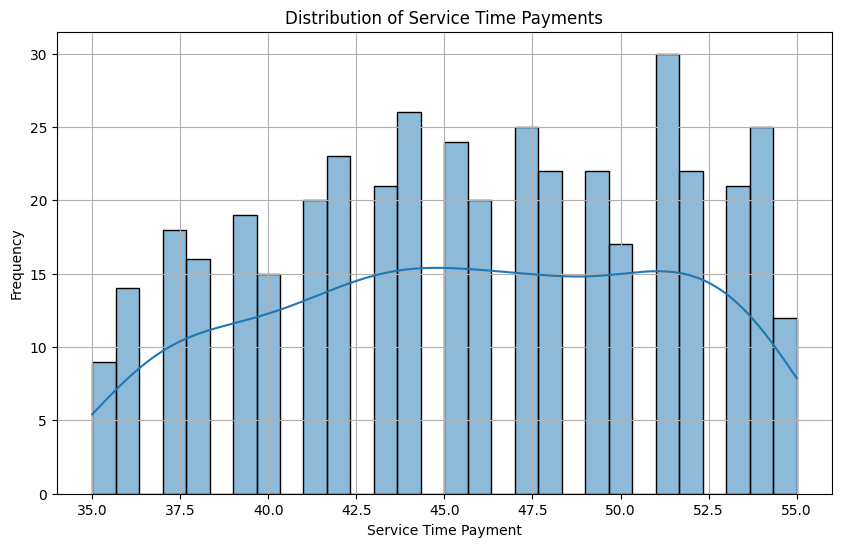

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Summary statistics for the "Service time payment" column
summary_stats = data['Service time payment'].describe()

# Histogram of the "Service time payment" column
plt.figure(figsize=(10, 6))
sns.histplot(data['Service time payment'], bins=30, kde=True)
plt.title('Distribution of Service Time Payments')
plt.xlabel('Service Time Payment')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [20]:
m1 = data['Service time payment'].mean()
m2 = np.mean([x**2 for x in data['Service time payment']])

estMean = m1
estStd = math.sqrt(m2 - m1**2)

fittedNormalDist = stats.norm(loc=estMean, scale=estStd)
test = stats.kstest(data['Service time payment'], fittedNormalDist.cdf)

print(test)


KstestResult(statistic=0.09018960917551688, pvalue=0.0019795467188055494, statistic_location=51, statistic_sign=-1)


In [21]:
# calculate the test statistics such as mean, std , skewness, kurtosis, median, mode, range, min, max, 25th percentile, 50th percentile, 75th percentile of the payment service time column
def calculate_statistics(data, attributes):
    """
    Calculate the test statistics such as mean, std , skewness, kurtosis, median, mode, range, min, max, 25th percentile, 50th percentile, 75th percentile of the payment service time.
    
    Args:
    - data (pd.DataFrame): Preprocessed data.
    
    Returns:
    - statistics (pd.DataFrame): Dataframe of summary statistics.
    """
    # Calculate the test statistics
    statistics = [{
        'Mean': data[attribute].mean(),
        'Std': data[attribute].std(),
        'Skewness': data[attribute].skew(),
        'Kurtosis': data[attribute].kurtosis(),
        'Median': data[attribute].median(),
        'Mode': data[attribute].mode().values[0],
        'Range': data[attribute].max() - data[attribute].min(),
        'Min': data[attribute].min(),
        'Max': data[attribute].max(),
        '25th Percentile': data[attribute].quantile(0.25),
        '50th Percentile': data[attribute].quantile(0.50),
        '75th Percentile': data[attribute].quantile(0.75)
    } for attribute in attributes]
    
    
    # Convert the statistics list to a DataFrame for easier manipulation
    statistics = pd.DataFrame(statistics, index=attributes).T
    # round to 4 sf
    statistics = statistics.round(4)
    
        
    return tabulate(statistics, headers='keys', tablefmt='pretty')
        
    
    
    # return tabulate(statistics.items(), headers=['Statistics', attribute], tablefmt='pretty')
    # return statistics

statistics = calculate_statistics(data, ['Service time Fuel', 'Shop time', 'Service time payment', 'Interarrival Times', "Arrival Time (H)"])
# print(statistics)
# print(tabulate(statistics.items(), headers=['Statistics', 'Value'], tablefmt='fancy_grid'))

print(statistics)

+-----------------+-------------------+-----------+----------------------+--------------------+------------------+
|                 | Service time Fuel | Shop time | Service time payment | Interarrival Times | Arrival Time (H) |
+-----------------+-------------------+-----------+----------------------+--------------------+------------------+
|      Mean       |     289.9905      |  15.7126  |       45.6603        |      136.6612      |     13.5677      |
|       Std       |      150.114      |  44.5069  |        5.6283        |      138.1222      |      4.6016      |
|    Skewness     |      1.0433       |  4.3502   |       -0.1223        |       1.8562       |      -0.041      |
|    Kurtosis     |      1.4368       |  26.1012  |       -1.0846        |       4.093        |     -1.2255      |
|     Median      |       272.0       |    0.0    |         46.0         |       96.513       |       14.0       |
|      Mode       |       177.0       |    0.0    |         51.0         |      

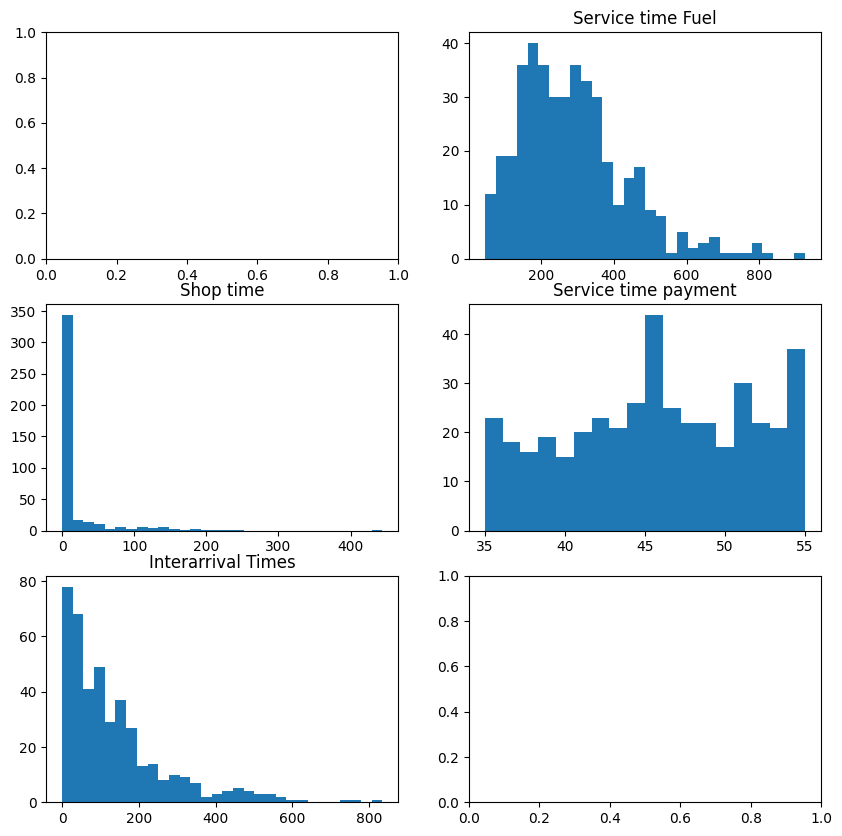

In [22]:
fig, axs = plt.subplots(3, 2, figsize=(10, 10))


axs[0,1].hist(data["Service time Fuel"], bins=30)
axs[0,1].set_title("Service time Fuel")

axs[1,0].hist(data["Shop time"], bins=30)
axs[1,0].set_title("Shop time")

axs[1,1].hist(data["Service time payment"], bins=18)
axs[1,1].set_title("Service time payment")

axs[2,0].hist(data["Interarrival Times"], bins=30)
axs[2,0].set_title("Interarrival Times")

# axs[0,0].hist(interarrival_times, bins=30)
# axs[1].hist(fuel_time, bins=20)
# axs[2].hist(shop_time, bins= math.floor(np.sqrt(len(shop_time))))
# axs[2].set_xlim(0, 200)

# show the plot
plt.show()

__Testing underlying distributions__

In [23]:
# conver the shop time into a binary variable
shop_time = data["Shop time"]
shop_time = shop_time.apply(lambda x: 1 if x > 0 else 0)

count_1 = shop_time[shop_time == 1].count()
count_0 = shop_time[shop_time == 0].count()

percentage_1 = count_1 / (count_1 + count_0)
percentage_0 = count_0 / (count_1 + count_0)

# print (percentage_0, percentage_1)



def calculate_shop_probabilities(data):
    """
    Calculate the probabilities of having a shop time and the conditional probabilities of having a shop time or not.
    
    Parameters:
    - data (pd.DataFrame): DataFrame containing shop times.
    
    Returns:
    - probabilities (dict): Dictionary containing calculated probabilities.
    """
    shop_time = data["Shop time"]
    total_len = len(shop_time)
    has_shop_time = shop_time[shop_time > 0]
    
    probabilities = {
        "probability_of_shop_time": len(has_shop_time) / total_len,
        "probability_of_no_shop_time": 1 - len(has_shop_time) / total_len,
        "count_total": total_len,
        "count_shop_time": len(has_shop_time),
    }
    
    
    return probabilities

def test_binomial_distribution(probabilities, alternative="two-sided", p_value = 0.05):
    """
    Test for binomial distribution of shop time.
    
    Parameters:
    - probabilities (dict): Dictionary containing calculated probabilities.
    - total_len (int): Total number of shop times.
    
    Returns:
    - test_results (dict): Dictionary containing test results.
    """
    test_results = {
        "test_for_shop_time_binom": stats.binomtest(
            probabilities["count_shop_time"],
            probabilities["count_total"],
            p=probabilities["probability_of_shop_time"],
            alternative=alternative
        ),
    }
    
    formatted_results = [{"Test": key, "Result": value, "Significance":value.pvalue>=p_value} for key, value in test_results.items()]
    
    # Use tabulate to format the output
    print(tabulate(formatted_results, headers="keys", tablefmt="pretty"))
    return test_results


# Calculate the probabilities
shop_probabilities = calculate_shop_probabilities(data)
pprint(shop_probabilities)
# test_results = test_binomial_distribution(shop_probabilities)

{'count_shop_time': 94,
 'count_total': 421,
 'probability_of_no_shop_time': 0.7767220902612827,
 'probability_of_shop_time': 0.22327790973871733}


In [24]:
def calculate_preference_probabilities(data):
    """
    Calculate the probabilities of having a parking preference and the conditional probabilities of preferring right or left.
    
    Parameters:
    - data (pd.DataFrame): DataFrame containing parking preferences.
    
    Returns:
    - probabilities (dict): Dictionary containing calculated probabilities.
    """
    preferences = data["Parking Preference"]
    total_len = len(preferences)
    has_preference = preferences[(preferences == "Right") | (preferences == "Left")]
    
    probabilities = {
        "probability_of_preference": len(has_preference) / total_len,
        "probability_of_no_preference": 1 - len(has_preference) / total_len,
        "probability_of_right": has_preference[has_preference == "Right"].count() / len(has_preference),
        "probability_of_left": has_preference[has_preference == "Left"].count() / len(has_preference),
        "count_total": total_len,
        "count_preference": len(has_preference),
        "count_right": has_preference[has_preference == "Right"].count(),
        "count_left": has_preference[has_preference == "Left"].count()
        
    }
    
    return probabilities

def test_binomial_distribution(probabilities, alternative="two-sided", p_value = 0.05):
    """
    Test for binomial distribution of preference and left/right parking preferences.
    
    Parameters:
    - probabilities (dict): Dictionary containing calculated probabilities.
    - total_len (int): Total number of parking preferences.
    
    Returns:
    - test_results (dict): Dictionary containing test results.
    """
    test_results = {
        "test_for_preference": stats.binomtest(
            probabilities["count_preference"],
            probabilities["count_total"],
            p=probabilities["probability_of_preference"],
            alternative=alternative
        ),
        "test_for_left": stats.binomtest(
            probabilities["count_left"],
            (probabilities["count_preference"]),
            p=probabilities["probability_of_left"],
            alternative=alternative
            
        ),
        "test_for_right": stats.binomtest(
            probabilities["count_right"],
            (probabilities["count_preference"]),
            p=probabilities["probability_of_right"],
            alternative=alternative
    
        ),
    }    
    
    formatted_results = [{"Test": key, "Result": value, "Significance":value.pvalue>=p_value} for key, value in test_results.items()]
    
    # Use tabulate to format the output
    print(tabulate(formatted_results, headers="keys", tablefmt="pretty"))
    return test_results


# Calculate the probabilities
preferences_probabilities = calculate_preference_probabilities(data)
test_results = test_binomial_distribution(preferences_probabilities)



+---------------------+------------------------------------------------------------------------------------------------+--------------+
|        Test         |                                             Result                                             | Significance |
+---------------------+------------------------------------------------------------------------------------------------+--------------+
| test_for_preference | BinomTestResult(k=72, n=421, alternative='two-sided', statistic=0.171021377672209, pvalue=1.0) |     True     |
|    test_for_left    | BinomTestResult(k=40, n=72, alternative='two-sided', statistic=0.5555555555555556, pvalue=1.0) |     True     |
|   test_for_right    | BinomTestResult(k=32, n=72, alternative='two-sided', statistic=0.4444444444444444, pvalue=1.0) |     True     |
+---------------------+------------------------------------------------------------------------------------------------+--------------+


In [25]:
def analyze_distributions(data, list_of_attributes):
    """
    Analyze the distributions of the given attributes in the data.
    :param data: 
    :param list_of_attributes: 
    :return: 
    """
    results = []

    output_parameters = {}

    # when calculating distribution of shop time we remove non zeroes
    for attribute in list_of_attributes:
        if attribute == "Shop time":
            data = data[data[attribute] > 0]
        
        output_parameters[attribute] = {}
 
        
        # m = np.mean(data[attribute])
        # fit_uniform_dist = stats.uniform(loc=0, scale=2 * m)
        
        fit_uniform_dist = stats.uniform(loc=(data[attribute].min()), scale=data[attribute].max() - data[attribute].min())
        
        test = stats.kstest(data[attribute], fit_uniform_dist.cdf)

        
        p_value = test[1]
        fit_status = "Good fit" if p_value > 0.05 else "Bad fit"
        results.append([attribute, "Uniform Distribution", fit_status, p_value])
        output_parameters[attribute]["Uniform Distribution"] = ({
            "loc" : data[attribute].min(),
            "scale": data[attribute].max() - data[attribute].min()
        })
        

        # Exponential distribution
        m1 = np.mean(data[attribute])
        fit_exponential_dist = stats.expon(scale=1 / m1)
        test = stats.kstest(data[attribute], fit_exponential_dist.cdf)
        p_value = test[1]
        fit_status = "Good fit" if p_value > 0.05 else "Bad fit"
        results.append([attribute, "Exponential Distribution", fit_status, p_value])
        output_parameters[attribute]["Exponential Distribution"] = ({
            "estimated_lambda": 1 / m1
        })

        
        # Gamma distribution
        m2 = np.mean([x**2 for x in data[attribute]])
        est_beta = m1 / (m2 - m1**2)
        est_alpha = m1 * est_beta
        fit_gamma_dist = stats.gamma(a=est_alpha, scale=1 / est_beta)
        test = stats.kstest(data[attribute], fit_gamma_dist.cdf)
        p_value = test[1]
        fit_status = "Good fit" if p_value > 0.05 else "Bad fit"
        results.append([attribute, "Gamma Distribution", fit_status, p_value])
        output_parameters[attribute]["Gamma Distribution"] =({
            "estimated_alpha": est_alpha,
            "estimated_beta": est_beta
        })

        # Poisson distribution
        fit_poisson_dist = stats.poisson(mu=m1)
        test = stats.kstest(data[attribute], fit_poisson_dist.cdf)
        p_value = test[1]
        fit_status = "Good fit" if p_value > 0.05 else "Bad fit"
        results.append([attribute, "Poisson Distribution", fit_status, p_value])
        
        output_parameters[attribute]["Poisson Distribution"]=({
            "estimated_lambda": m1
        })

        # Normal distribution
        estimated_std = math.sqrt(m2 - m1**2)
        fit_normal_dist = stats.norm(loc=m1, scale=estimated_std)
        test = stats.kstest(data[attribute], fit_normal_dist.cdf)
        p_value = test[1]
        fit_status = "Good fit" if p_value > 0.05 else "Bad fit"
        results.append([attribute, "Normal Distribution", fit_status, p_value])
        
        output_parameters[attribute]["Normal Distribution"]=({
            "estimated_mean": m1,
            "estimated_std": estimated_std
        })

    # Convert the results list to a DataFrame for easier manipulation
    results_df = pd.DataFrame(results, columns=["Attribute", "Distribution", "Fit Status", "P-value"])

    return results_df, output_parameters

list_of_attributes = ["Service time Fuel", "Service time payment", "Interarrival Times", "Shop time"]
fit_status, parameters = analyze_distributions(data, list_of_attributes)
print(tabulate(fit_status, headers='keys', tablefmt='pretty'))

+----+----------------------+--------------------------+------------+-------------------------+
|    |      Attribute       |       Distribution       | Fit Status |         P-value         |
+----+----------------------+--------------------------+------------+-------------------------+
| 0  |  Service time Fuel   |   Uniform Distribution   |  Bad fit   | 1.5905430930180325e-64  |
| 1  |  Service time Fuel   | Exponential Distribution |  Bad fit   |           0.0           |
| 2  |  Service time Fuel   |    Gamma Distribution    |  Good fit  |   0.8995139987322393    |
| 3  |  Service time Fuel   |   Poisson Distribution   |  Bad fit   |  3.020669518714976e-77  |
| 4  |  Service time Fuel   |   Normal Distribution    |  Bad fit   |  0.040874611008199224   |
| 5  | Service time payment |   Uniform Distribution   |  Bad fit   |   0.00352204327327805   |
| 6  | Service time payment | Exponential Distribution |  Bad fit   |           0.0           |
| 7  | Service time payment |    Gamma D

In [26]:
def selecting_distribution(fit_status, parameters):
    """
    Select the best distribution for each attribute.
    
    Parameters:
    - fit_status (pd.DataFrame): DataFrame containing the results of the distribution analysis.
    - parameters (dict): Dictionary containing the parameters of the distributions.
    
    Returns:
    - selected_distributions (dict): Dictionary containing the selected distributions for each attribute.
    """
    selected_distributions = {}
    
    # Filter the parameters DataFrame to only include good fits
    good_fits = fit_status[fit_status["Fit Status"] == "Good fit"]
    
    # Create a dictionary to store the distribution type and p-value for each attribute
    dist_type = {}
    
    # Iterate over the good fits
    for index, row in good_fits.iterrows():
        # If the attribute is not in the dictionary, add it
        if row["Attribute"] not in dist_type:
            dist_type[row["Attribute"]] = (row["Distribution"], row["P-value"])
        # If the p-value is higher than the current p-value, update the distribution type
        else:
            if row["P-value"] > dist_type[row["Attribute"]][1]:
                dist_type[row["Attribute"]] = (row["Distribution"], row["P-value"])
    
    # Create a dictionary to store the parameters of the selected distributions
    results = {}
    
    # Iterate over the distribution types
    for attribute, value in dist_type.items():
        # Add the distribution type and parameters to the results dictionary
        results[attribute] = (value[0], parameters[attribute][value[0]])
    
    # Return the selected distributions
    return results

# Select the best distribution for each attribute
selected_distributions = selecting_distribution(fit_status, parameters)

pprint(selected_distributions)

{'Interarrival Times': ('Gamma Distribution',
                        {'estimated_alpha': 0.9812872350062886,
                         'estimated_beta': 0.007180438865738716}),
 'Service time Fuel': ('Gamma Distribution',
                       {'estimated_alpha': 3.740741878984356,
                        'estimated_beta': 0.012899532551254148}),
 'Shop time': ('Gamma Distribution',
               {'estimated_alpha': 0.9896321424751765,
                'estimated_beta': 0.014062799908188449})}


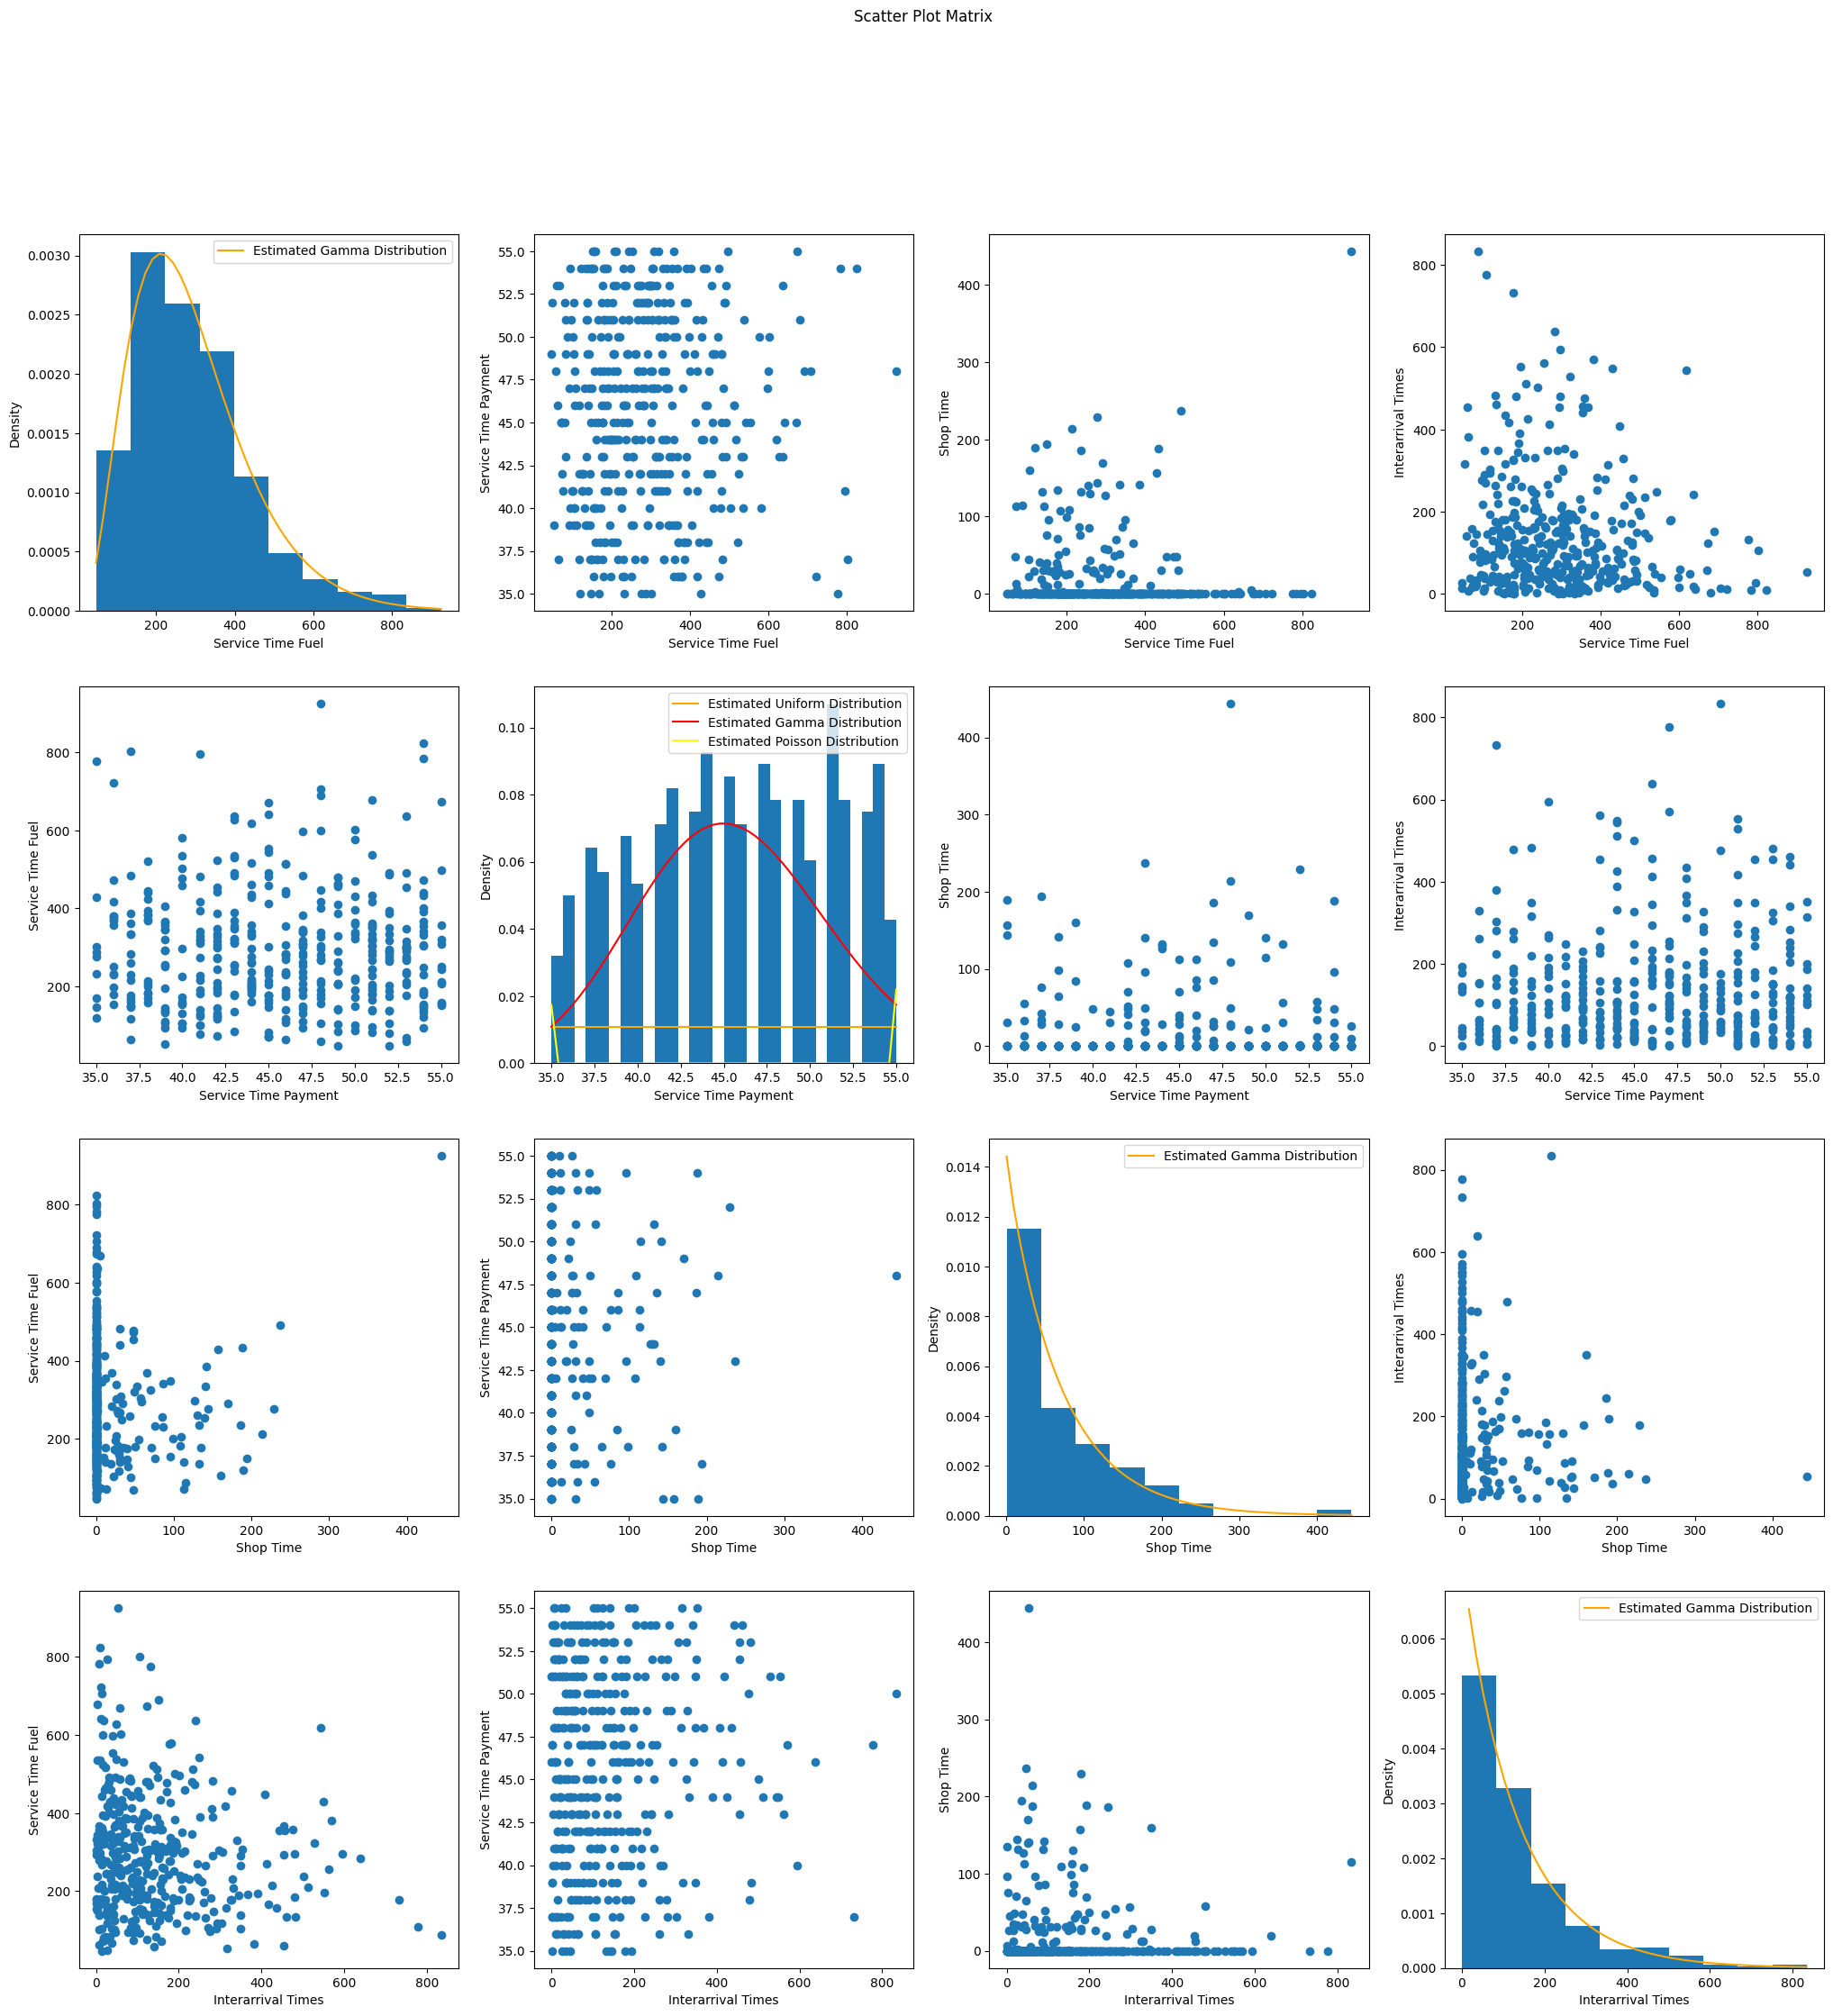

In [31]:
# SPLOM
fig, axs = plt.subplots(4, 4, figsize=(25, 25))


axs[0,0].hist(data["Service time Fuel"], density=True)
axs[0,0].set_xlabel("Service Time Fuel")
axs[0,0].set_ylabel("Density")
x = np.linspace(data["Service time Fuel"].min(), data["Service time Fuel"].max())
y = stats.gamma(a=parameters["Service time Fuel"]["Gamma Distribution"]["estimated_alpha"], scale=1 / parameters["Service time Fuel"]["Gamma Distribution"]["estimated_beta"]).pdf(x)
axs[0,0].plot(
    x,
    y,
    label="Estimated Gamma Distribution",
    color="orange"
 )
  # $\alpha$ "+ f"= {round(parameters['Service time Fuel']['Gamma Distribution']['estimated_alpha'])}, $\beta$$"+f" = {round(parameters['Service time Fuel']['Gamma Distribution']['estimated_beta'])}"),
axs[0,0].legend(loc="upper right")


axs[0,1].scatter(data["Service time Fuel"], data["Service time payment"])
axs[0,1].set_xlabel("Service Time Fuel")
axs[0,1].set_ylabel("Service Time Payment")

axs[0,2].scatter(data["Service time Fuel"], data["Shop time"])
axs[0,2].set_xlabel("Service Time Fuel")
axs[0,2].set_ylabel("Shop Time")

axs[0,3].scatter(data["Service time Fuel"], data["Interarrival Times"])
axs[0,3].set_xlabel("Service Time Fuel")
axs[0,3].set_ylabel("Interarrival Times")



axs[1,0].scatter(data["Service time payment"], data["Service time Fuel"])
axs[1,0].set_xlabel("Service Time Payment")
axs[1,0].set_ylabel("Service Time Fuel")

axs[1,1].hist(data["Service time payment"],bins=30, density=True)
axs[1,1].set_xlabel("Service Time Payment")
axs[1,1].set_ylabel("Density")

# plot uniform distribution

x = np.linspace(data["Service time payment"].min(), data["Service time payment"].max())
y_uni = stats.uniform(loc=0, scale=2 * data["Service time payment"].mean()).pdf(x)

# plot gamma distribution
y_gamma = stats.gamma(a=parameters["Service time payment"]["Gamma Distribution"]["estimated_alpha"], scale=1 / parameters["Service time payment"]["Gamma Distribution"]["estimated_beta"]).pdf(x)

# plot poisson distribution

y_poisson = stats.poisson.pmf(x, data["Service time payment"].mean())

axs[1,1].plot(
    x,
    y_uni,
    label="Estimated Uniform Distribution",
    color="orange"
 )
axs[1,1].plot(
    x,
    y_gamma,
    label="Estimated Gamma Distribution",
    color="red"
 )
axs[1,1].plot(
    x,
    y_poisson,
    label="Estimated Poisson Distribution",
    color="yellow"
 )

axs[1,1].legend(loc="upper right")


axs[1,2].scatter(data["Service time payment"], data["Shop time"])
axs[1,2].set_xlabel("Service Time Payment")
axs[1,2].set_ylabel("Shop Time")


axs[1,3].scatter(data["Service time payment"], data["Interarrival Times"])
axs[1,3].set_xlabel("Service Time Payment")
axs[1,3].set_ylabel("Interarrival Times")

axs[2,0].scatter(data["Shop time"], data["Service time Fuel"])
axs[2,0].set_xlabel("Shop Time")
axs[2,0].set_ylabel("Service Time Fuel")

axs[2,1].scatter(data["Shop time"], data["Service time payment"])
axs[2,1].set_xlabel("Shop Time")
axs[2,1].set_ylabel("Service Time Payment")


shop_data = data[data["Shop time"] > 0]

axs[2,2].hist(shop_data["Shop time"], density=True )
axs[2,2].set_xlabel("Shop Time")
axs[2,2].set_ylabel("Density")
# plot the gamma distribution
x = np.linspace(shop_data["Shop time"].min(), shop_data["Shop time"].max())
y = stats.gamma(a=parameters["Shop time"]["Gamma Distribution"]["estimated_alpha"], scale=1 / parameters["Shop time"]["Gamma Distribution"]["estimated_beta"]).pdf(x)

axs[2,2].plot(
    x,
    y,
    label="Estimated Gamma Distribution",
    color="orange"
 )
axs[2,2].legend(loc="upper right")


axs[2,3].scatter(data["Shop time"], data["Interarrival Times"])
axs[2,3].set_xlabel("Shop Time")
axs[2,3].set_ylabel("Interarrival Times")



axs[3,0].scatter(data["Interarrival Times"], data["Service time Fuel"])
axs[3,0].set_xlabel("Interarrival Times")
axs[3,0].set_ylabel("Service Time Fuel")

axs[3,1].scatter(data["Interarrival Times"], data["Service time payment"])
axs[3,1].set_xlabel("Interarrival Times")
axs[3,1].set_ylabel("Service Time Payment")



axs[3,2].scatter(data["Interarrival Times"], data["Shop time"])
axs[3,2].set_xlabel("Interarrival Times")
axs[3,2].set_ylabel("Shop Time")

axs[3,3].hist( data["Interarrival Times"], density=True)
axs[3,3].set_xlabel("Interarrival Times")
axs[3,3].set_ylabel("Density")

x = np.linspace(data["Interarrival Times"].min(), data["Interarrival Times"].max())
y = stats.gamma(a=parameters["Interarrival Times"]["Gamma Distribution"]["estimated_alpha"], scale=1 / parameters["Interarrival Times"]["Gamma Distribution"]["estimated_beta"]).pdf(x)

axs[3,3].plot(
    x,
    y,
    label="Estimated Gamma Distribution",
    color="orange"
 )
axs[3,3].legend(loc="upper right")


# set the title to the SPLOM

plt.suptitle("Scatter Plot Matrix")

plt.show()




In [28]:
import plotly.express as px

def left_right_encoder(x):
    if x == "Left":
        return -1
    elif x == "Right":
        return 1
    else:
        return 0


data["Parking Preference (L=-1, R=1)"] = data["Parking Preference"].apply(lambda x: left_right_encoder(x))
px.parallel_coordinates(
    data_frame=data,
    dimensions=[
        "Parking Preference (L=-1, R=1)",
        "Interarrival Times",
        "Shop time",
        "Service time Fuel",
        "Service time payment",
        
    ],
    color="Arrival Time (H)",
    labels={
        "Parking Preference (L=-1, R=1)": "Parking Preference",
        "Interarrival Times": "Interarrival Times",
        "Shop time": "Shop Time",
        "Service time Fuel": "Service Time Fuel",
        "Service time payment": "Service Time payment",
    },
    title="Parallel Coordinates Plot",
    color_continuous_scale="viridis",
)



Text(0.5, 0.98, 'Distribution of Arrivals in the Day')

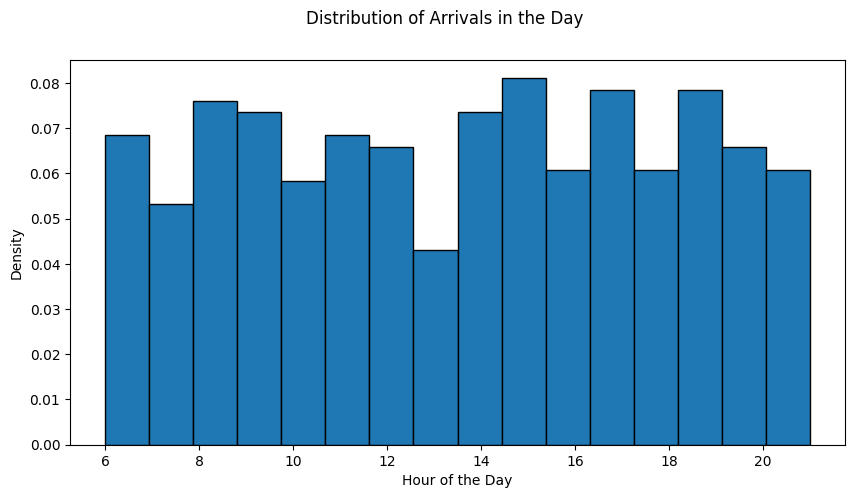

In [29]:
# plot a histogram of frequency of arrival times in the day
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(data["Arrival Time (H)"], bins=16, edgecolor="black", density=True)

ax.set_xlabel("Hour of the Day")
ax.set_ylabel("Density")
fig.suptitle("Distribution of Arrivals in the Day")

# Exploring Service Time Payment (include exploration this in your section)

Based on these visualizations,the data does not appear to be strongly multimodal.

In [36]:
fit_uniform_dist = stats.uniform(loc=(data["Service time payment"].min()), scale=data["Service time payment"].max() - data["Service time payment"].min())   
test = stats.kstest(data["Service time payment"], fit_uniform_dist.cdf)
print(test)

m1 = np.mean(data["Service time payment"])
fit_poisson_dist = stats.poisson(mu=m1)
test = stats.kstest(data["Service time payment"], fit_poisson_dist.cdf)
print(test)
print(m1)

KstestResult(statistic=0.0863420427553444, pvalue=0.00352204327327805, statistic_location=42, statistic_sign=-1)
KstestResult(statistic=0.08156732196387562, pvalue=0.0069522316787299894, statistic_location=47, statistic_sign=-1)
45.6603325415677


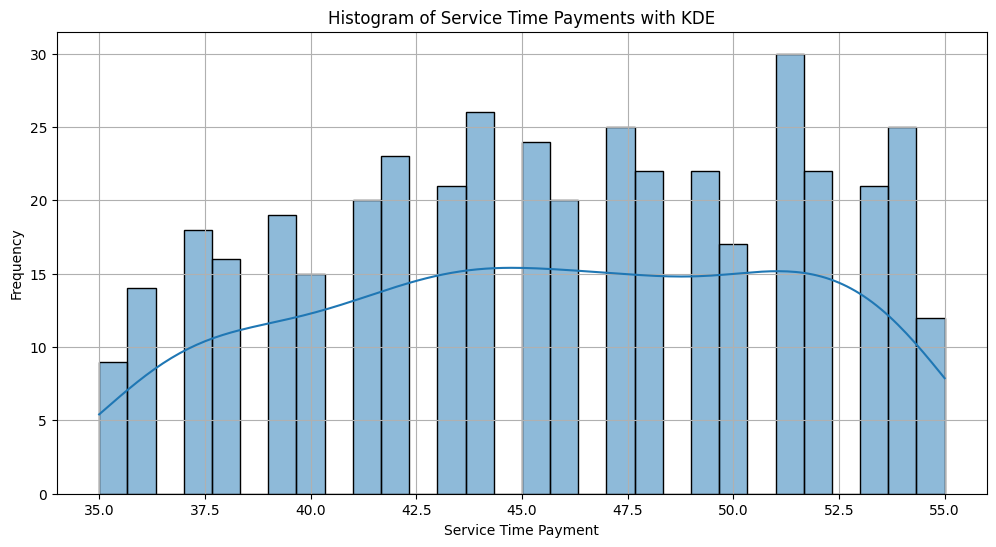

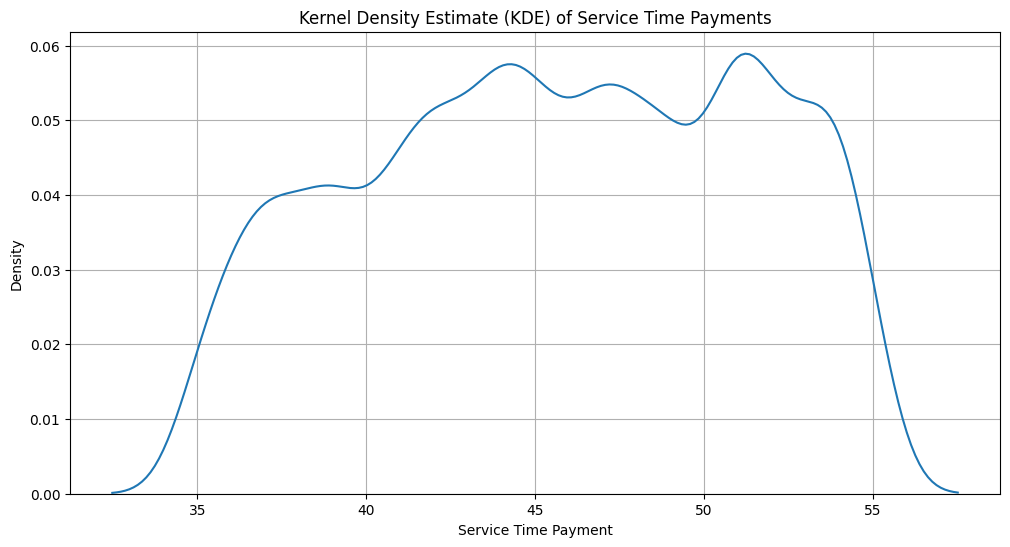

In [30]:
# Checking for multimodality
plt.figure(figsize=(12, 6))
sns.histplot(data['Service time payment'], bins=30, kde=True)
plt.title('Histogram of Service Time Payments with KDE')
plt.xlabel('Service Time Payment')
plt.ylabel('Frequency')
plt.grid(True)

# Adding a more detailed Kernel Density Estimate (KDE) plot to help identify potential modes
plt.figure(figsize=(12, 6))
sns.kdeplot(data['Service time payment'], bw_adjust=0.5)
plt.title('Kernel Density Estimate (KDE) of Service Time Payments')
plt.xlabel('Service Time Payment')
plt.ylabel('Density')
plt.grid(True)
plt.show()

The blue bars show the observed frequencies of each unique "Service time payment" value. These are the actual counts from the dataset you provided. Each bar's height indicates how many times a particular payment value occurs in the data. For instance, if a bar reaches up to a height of 20, it means that particular service time payment was observed 20 times in the dataset.

The red dots represent the expected frequencies for each service time payment value as predicted by a Poisson distribution with a mean equal to the average of the observed data. The height of each red cross corresponds to the number of occurrences that the Poisson distribution would predict for that specific payment value.

Based on:
1. the visualization below
2. the fact that our data set is very small in size
3. p value from ks-test

we conclude that poisson might be the underlying distribution of the service payment time

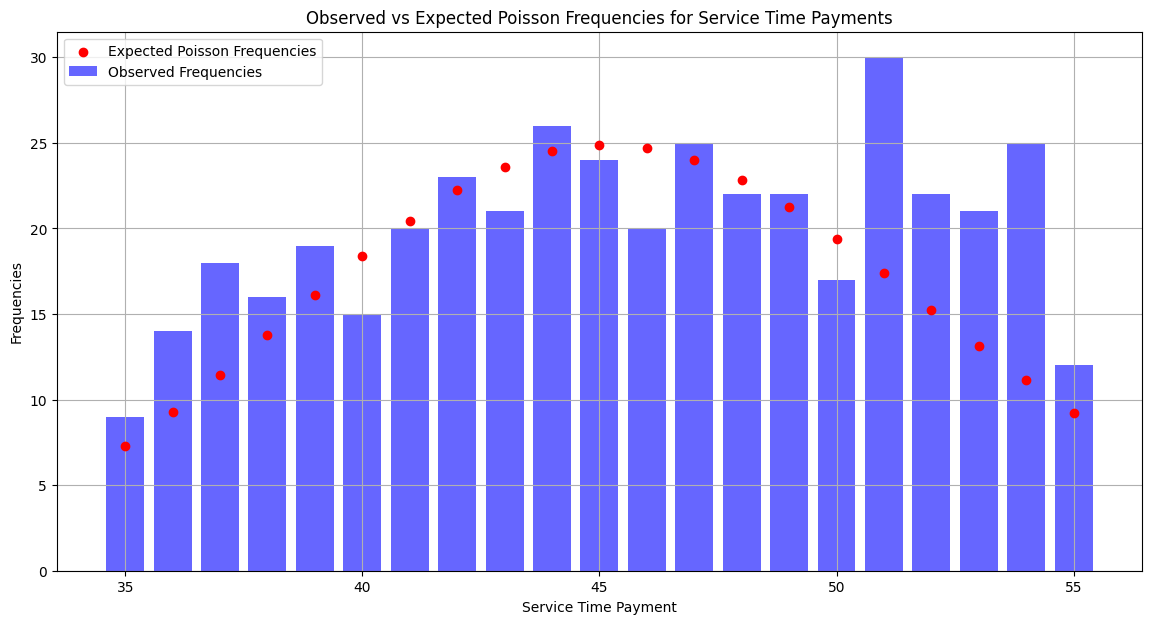

In [34]:
# Calculate the observed frequencies for each unique value
observed_frequencies = data['Service time payment'].value_counts().sort_index()

# λ for the Poisson distribution from the data
lambda_poisson = data['Service time payment'].mean()

# Re-create the Poisson distribution object
poisson_dist = stats.poisson(mu=lambda_poisson)

# Recalculate the expected Poisson frequencies for each unique value
expected_frequencies_poisson = poisson_dist.pmf(observed_frequencies.index) * len(data)

# Create a bar chart for the observed frequencies
plt.figure(figsize=(14, 7))
plt.bar(observed_frequencies.index, observed_frequencies, label='Observed Frequencies', color='blue', alpha=0.6)

# Add a scatter plot for the expected Poisson frequencies
plt.scatter(observed_frequencies.index, expected_frequencies_poisson, color='red', label='Expected Poisson Frequencies', zorder=2)

plt.title('Observed vs Expected Poisson Frequencies for Service Time Payments')
plt.xlabel('Service Time Payment')
plt.ylabel('Frequencies')
plt.legend()
plt.grid(True)
plt.show()